In [1]:
import pandas as pd
from matplotlib import pylab as plt

In [2]:
#extracting the airline dataset
dataframe = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skip_footer=3)

/home/owoshch/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: The 'skip_footer' argument has been deprecated and will be removed in a future version. Please use the 'skipfooter' argument instead.
  from ipykernel import kernelapp as app


In [4]:
import tensorflow as tf
import numpy as np
import math


In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [6]:
# Fixing the random number seed to ensure results are reprodusable
np.random.seed(7)

In [7]:
dataframe.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


In [8]:
dataset = dataframe.values

In [9]:
dataset[:5]

array([[112],
       [118],
       [132],
       [129],
       [121]])

In [10]:
dataset = dataset.astype('float32')

In [11]:
#normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [12]:
#split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print len(train), len(test)

96 48


In [13]:
#making a function to create a new dataset
#dataset is numpy array
#look_back is the number of previous time steps to use as imput variables to predict the next time period
#default func will create a dataset where X is the number of passengers at a given time (t)
# Y is the number of passengers at the next time (t+1)
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        next_portion = dataset[i:(i + look_back), 0]
        dataX.append(next_portion)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [14]:
print create_dataset(dataframe.values)[0][:5]
print create_dataset(dataframe.values)[1][:5]

[[112]
 [118]
 [132]
 [129]
 [121]]
[118 132 129 121 135]


In [15]:
#reshape into X = t and Y = t + 1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data(X) to be provided with a specific array structure in the form of:
[samples, time steps, features]

In [16]:
#reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [17]:
#create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim = look_back))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [19]:
model.fit(trainX, trainY, nb_epoch = 100, batch_size = 1, verbose=2)

Epoch 1/100
0s - loss: 0.0321
Epoch 2/100
0s - loss: 0.0147
Epoch 3/100
0s - loss: 0.0116
Epoch 4/100
0s - loss: 0.0106
Epoch 5/100
0s - loss: 0.0097
Epoch 6/100
0s - loss: 0.0089
Epoch 7/100
0s - loss: 0.0083
Epoch 8/100
0s - loss: 0.0074
Epoch 9/100
0s - loss: 0.0066
Epoch 10/100
0s - loss: 0.0058
Epoch 11/100
0s - loss: 0.0052
Epoch 12/100
0s - loss: 0.0045
Epoch 13/100
0s - loss: 0.0040
Epoch 14/100
0s - loss: 0.0034
Epoch 15/100
0s - loss: 0.0031
Epoch 16/100
0s - loss: 0.0028
Epoch 17/100
0s - loss: 0.0026
Epoch 18/100
0s - loss: 0.0024
Epoch 19/100
0s - loss: 0.0023
Epoch 20/100
0s - loss: 0.0022
Epoch 21/100
0s - loss: 0.0021
Epoch 22/100
0s - loss: 0.0021
Epoch 23/100
0s - loss: 0.0021
Epoch 24/100
0s - loss: 0.0021
Epoch 25/100
0s - loss: 0.0020
Epoch 26/100
0s - loss: 0.0021
Epoch 27/100
0s - loss: 0.0020
Epoch 28/100
0s - loss: 0.0021
Epoch 29/100
0s - loss: 0.0020
Epoch 30/100
0s - loss: 0.0020
Epoch 31/100
0s - loss: 0.0021
Epoch 32/100
0s - loss: 0.0020
Epoch 33/100
0s -

In [20]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.57 RMSE
Test Score: 51.02 RMSE


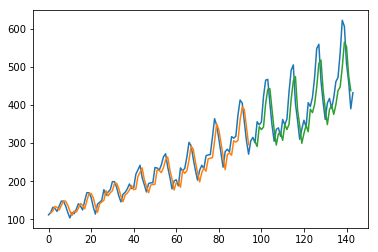

In [21]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()